In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
from torchsummary import summary
import time
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
!mkdir data
data_dir = Path('./data')
net_fn = Path('./net')
import math
torch.manual_seed(0)
np.random.seed(0)
from prettytable import PrettyTable
!pip install pthflops
from pthflops import count_ops
import copy
!pip install torchinfo
import torchinfo
!pip install thop
from thop import profile
torch.manual_seed(0)
np.random.seed(0)
!pip install --upgrade efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from scipy.linalg import svd

PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=868cb17be9c048e3acabffb1013051b1a7fa2303afe1fe61f6833f9716654e89
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


In [2]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Mount data directory to google drive
"""
Used the comments in code to execute the file
"""
from google.colab import drive
drive.mount('/content/drive')

# Copy to local for faster extraction
!cp /content/drive/Shareddrives/539/ILSVRC2012_img_val.tar ./data
!cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t3.tar.gz ./data
!cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t12.tar.gz ./data

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create validation dataset
val_dataset = datasets.ImageNet('./data', split='val', transform=val_transform)

# Create validation dataloader
val_dataloader = torch.utils.data.DataLoader(val_dataset, num_workers=4)

print(f'Number of validation images: {len(val_dataset)}')


Mounted at /content/drive
Number of validation images: 50000


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
def validate_model(model, dataloader, device="cpu", n=None):
    model.eval()
    running_corrects = 0
    total = 0

    # Move model to device (CPU or GPU)
    # One time to amortize data movement
    dev = torch.device(device)
    model.to(dev)

    # Iterate over data stopping early if n is set
    for i, (inputs, labels) in enumerate(dataloader):
        if (n is not None and i >= n):
            break
        # Send inputs to device
        inputs = inputs.to(dev)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        """
        """
        temp = labels.data
        if(device=="cuda"):
          temp = temp.to(device="cuda")


        # Gather statistics
        running_corrects += torch.sum(predicted == temp)
        total += inputs.size()[0]       # get batch size

        if i % 200 == 199:
            acc = 100 * running_corrects.double() / total
            print(f'[{i + 1}] {acc:.4f}%')

    epoch_acc = 100 * running_corrects.double() / total

    return epoch_acc


In [5]:
model_0 = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [7]:
model_1 = EfficientNet.from_pretrained('efficientnet-b1')


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b1


In [8]:
model_2 = EfficientNet.from_pretrained('efficientnet-b2')


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


In [9]:
model_3 = EfficientNet.from_pretrained('efficientnet-b3')


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


In [10]:
model_4 = EfficientNet.from_pretrained('efficientnet-b4')


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


In [11]:
model_5 = EfficientNet.from_pretrained('efficientnet-b5')


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b5


In [12]:
model_6 = EfficientNet.from_pretrained('efficientnet-b6')


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b6


In [13]:
model_7 = EfficientNet.from_pretrained('efficientnet-b7')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


In [14]:
print(f'Validation Finished. Final Accuracy: {validate_model(model_0, val_dataloader, device="cuda", n=1024):.4f}%')
print(f'Validation Finished. Final Accuracy: {validate_model(model_1, val_dataloader, device="cuda", n=1024):.4f}%')
print(f'Validation Finished. Final Accuracy: {validate_model(model_2, val_dataloader, device="cuda", n=1024):.4f}%')
print(f'Validation Finished. Final Accuracy: {validate_model(model_3, val_dataloader, device="cuda", n=1024):.4f}%')
print(f'Validation Finished. Final Accuracy: {validate_model(model_4, val_dataloader, device="cuda", n=1024):.4f}%')
print(f'Validation Finished. Final Accuracy: {validate_model(model_5, val_dataloader, device="cuda", n=1024):.4f}%')
print(f'Validation Finished. Final Accuracy: {validate_model(model_6, val_dataloader, device="cuda", n=1024):.4f}%')
print(f'Validation Finished. Final Accuracy: {validate_model(model_7, val_dataloader, device="cuda", n=1024):.4f}%')


[200] 87.0000%
[400] 81.7500%
[600] 85.3333%
[800] 87.2500%
[1000] 87.9000%
Validation Finished. Final Accuracy: 87.8906%
[200] 87.5000%
[400] 82.5000%
[600] 86.6667%
[800] 88.5000%
[1000] 88.9000%
Validation Finished. Final Accuracy: 88.8672%
[200] 88.0000%
[400] 83.0000%
[600] 87.0000%
[800] 88.5000%
[1000] 88.8000%
Validation Finished. Final Accuracy: 88.7695%
[200] 89.5000%
[400] 84.2500%
[600] 87.8333%
[800] 89.5000%
[1000] 89.7000%
Validation Finished. Final Accuracy: 89.6484%
[200] 88.0000%
[400] 83.0000%
[600] 86.3333%
[800] 87.8750%
[1000] 88.3000%
Validation Finished. Final Accuracy: 88.1836%
[200] 85.0000%
[400] 80.7500%
[600] 85.0000%
[800] 86.5000%
[1000] 86.6000%
Validation Finished. Final Accuracy: 86.5234%
[200] 86.0000%
[400] 81.5000%
[600] 85.3333%
[800] 87.3750%
[1000] 87.0000%
Validation Finished. Final Accuracy: 86.9141%
[200] 88.5000%
[400] 82.0000%
[600] 86.0000%
[800] 88.1250%
[1000] 88.0000%
Validation Finished. Final Accuracy: 87.8906%


In [15]:
print(torchinfo.summary(model_0, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0))


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                       [1, 3, 224, 224]          [1, 1000]                 --                        --                        --
├─Conv2dStaticSamePadding: 1-1                     [1, 3, 224, 224]          [1, 32, 112, 112]         864                       [3, 3]                    --
│    └─ZeroPad2d: 2-1                              [1, 3, 224, 224]          [1, 3, 225, 225]          --                        --                        --
├─BatchNorm2d: 1-2                                 [1, 32, 112, 112]         [1, 32, 112, 112]         64                        --                        64
├─MemoryEfficientSwish: 1-3                        [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --                        --
├─ModuleList: 1-4                            

In [16]:
print(torchinfo.summary(model_1, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0))


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                       [1, 3, 224, 224]          [1, 1000]                 --                        --                        --
├─Conv2dStaticSamePadding: 1-1                     [1, 3, 224, 224]          [1, 32, 112, 112]         864                       [3, 3]                    --
│    └─ZeroPad2d: 2-1                              [1, 3, 224, 224]          [1, 3, 225, 225]          --                        --                        --
├─BatchNorm2d: 1-2                                 [1, 32, 112, 112]         [1, 32, 112, 112]         64                        --                        64
├─MemoryEfficientSwish: 1-3                        [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --                        --
├─ModuleList: 1-4                            

In [17]:
print(torchinfo.summary(model_2, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0))


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                       [1, 3, 224, 224]          [1, 1000]                 --                        --                        --
├─Conv2dStaticSamePadding: 1-1                     [1, 3, 224, 224]          [1, 32, 112, 112]         864                       [3, 3]                    --
│    └─ZeroPad2d: 2-1                              [1, 3, 224, 224]          [1, 3, 225, 225]          --                        --                        --
├─BatchNorm2d: 1-2                                 [1, 32, 112, 112]         [1, 32, 112, 112]         64                        --                        64
├─MemoryEfficientSwish: 1-3                        [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --                        --
├─ModuleList: 1-4                            

In [18]:
print(torchinfo.summary(model_3, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0))


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                       [1, 3, 224, 224]          [1, 1000]                 --                        --                        --
├─Conv2dStaticSamePadding: 1-1                     [1, 3, 224, 224]          [1, 40, 112, 112]         1,080                     [3, 3]                    --
│    └─ZeroPad2d: 2-1                              [1, 3, 224, 224]          [1, 3, 225, 225]          --                        --                        --
├─BatchNorm2d: 1-2                                 [1, 40, 112, 112]         [1, 40, 112, 112]         80                        --                        80
├─MemoryEfficientSwish: 1-3                        [1, 40, 112, 112]         [1, 40, 112, 112]         --                        --                        --
├─ModuleList: 1-4                            

In [19]:
print(torchinfo.summary(model_4, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0))


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                       [1, 3, 224, 224]          [1, 1000]                 --                        --                        --
├─Conv2dStaticSamePadding: 1-1                     [1, 3, 224, 224]          [1, 48, 112, 112]         1,296                     [3, 3]                    --
│    └─ZeroPad2d: 2-1                              [1, 3, 224, 224]          [1, 3, 225, 225]          --                        --                        --
├─BatchNorm2d: 1-2                                 [1, 48, 112, 112]         [1, 48, 112, 112]         96                        --                        96
├─MemoryEfficientSwish: 1-3                        [1, 48, 112, 112]         [1, 48, 112, 112]         --                        --                        --
├─ModuleList: 1-4                            

In [20]:
print(torchinfo.summary(model_5, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0))


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                       [1, 3, 224, 224]          [1, 1000]                 --                        --                        --
├─Conv2dStaticSamePadding: 1-1                     [1, 3, 224, 224]          [1, 48, 112, 112]         1,296                     [3, 3]                    --
│    └─ZeroPad2d: 2-1                              [1, 3, 224, 224]          [1, 3, 225, 225]          --                        --                        --
├─BatchNorm2d: 1-2                                 [1, 48, 112, 112]         [1, 48, 112, 112]         96                        --                        96
├─MemoryEfficientSwish: 1-3                        [1, 48, 112, 112]         [1, 48, 112, 112]         --                        --                        --
├─ModuleList: 1-4                            

In [21]:
print(torchinfo.summary(model_6, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0))


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                       [1, 3, 224, 224]          [1, 1000]                 --                        --                        --
├─Conv2dStaticSamePadding: 1-1                     [1, 3, 224, 224]          [1, 56, 112, 112]         1,512                     [3, 3]                    --
│    └─ZeroPad2d: 2-1                              [1, 3, 224, 224]          [1, 3, 225, 225]          --                        --                        --
├─BatchNorm2d: 1-2                                 [1, 56, 112, 112]         [1, 56, 112, 112]         112                       --                        112
├─MemoryEfficientSwish: 1-3                        [1, 56, 112, 112]         [1, 56, 112, 112]         --                        --                        --
├─ModuleList: 1-4                           

In [22]:
print(torchinfo.summary(model_7, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0))


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                       [1, 3, 224, 224]          [1, 1000]                 --                        --                        --
├─Conv2dStaticSamePadding: 1-1                     [1, 3, 224, 224]          [1, 64, 112, 112]         1,728                     [3, 3]                    --
│    └─ZeroPad2d: 2-1                              [1, 3, 224, 224]          [1, 3, 225, 225]          --                        --                        --
├─BatchNorm2d: 1-2                                 [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
├─MemoryEfficientSwish: 1-3                        [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
├─ModuleList: 1-4                           

In [23]:
for name, child in model_0.named_children():
  print(name)

_conv_stem
_bn0
_blocks
_conv_head
_bn1
_avg_pooling
_dropout
_fc
_swish


In [24]:
def reshape(layer):
  # Get the weights tensor from the layer
  weights = layer.weight
  
  # Get the shape of the weights tensor
  shape = list(weights.shape)
  
  # Reshape the weights tensor to a (1, shape[0], 27) shape
  weights_rs = torch.reshape(weights, (1, shape[0], 27))
  
  # Reshape the weights tensor to a (1, shape[0]*27) shape
  weights_rs = torch.reshape(weights_rs, (1,shape[0]*27))
  
  # Reshape the weights tensor to a (shape[0],27) shape
  weights_rs = torch.reshape(weights_rs, (shape[0],27))
  
  # Convert the weights tensor to a numpy array
  np_arr = weights_rs.detach().numpy()
  
  # Return the numpy array
  return np_arr
  
def centering(K):
    # Get the number of rows in K
    n = K.shape[0]
    
    # Create a centering matrix H
    H = np.eye(n) - np.ones([n, n]) / n

    # Return the product of H, K, and H
    return H @ K @ H


def rbf(X, sigma=None):
    # Calculate the dot product of X and the transpose of X
    GX = X @ X.T
    
    # Calculate the matrix KX
    KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
    
    # If sigma is not provided, calculate it based on the median distance in KX
    if sigma is None:
        mdist = np.median(KX[KX != 0])
        sigma = math.sqrt(mdist)
    
    # Modify KX based on sigma
    KX *= - 0.5 / (sigma * sigma)
    KX = np.exp(KX)
    
    # Return KX
    return KX


def kernel_HSIC(X, Y, sigma):
    # Calculate the kernel HSIC value
    return np.sum(centering(rbf(X, sigma)) * centering(rbf(Y, sigma)))

def linear_HSIC(X, Y):
    # Calculate the matrices L_X and L_Y
    L_X = X @ X.T
    L_Y = Y @ Y.T
    
    # Calculate the linear HSIC value
    return np.sum(centering(L_X) * centering(L_Y))

def linear_CKA(X, Y):
    # Calculate the linear HSIC value
    hsic = linear_HSIC(X, Y)
    
    # Calculate the variances
    var1 = np.sqrt(linear_HSIC(X, X))
    var2 = np.sqrt(linear_HSIC(Y, Y))

    # Calculate the linear CKA value
    return hsic / (var1 * var2)



def kernel_CKA(X, Y, sigma=None):
    # Calculate the kernel HSIC value
    hsic = kernel_HSIC(X, Y, sigma)
    
    # Calculate the variances
    var1 = np.sqrt(kernel_HSIC(X, X, sigma))
    var2 = np.sqrt(kernel_HSIC(Y, Y, sigma))

    # Calculate the kernel CKA value
    return hsic / (var1 * var2)

def padding(array, xx, yy):
    # Get the height and width of the array
    h = array.shape[0]
    w = array.shape[1]

    # Calculate the padding sizes
    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    # Return the padded array
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [25]:
temp_0 = model_0._conv_stem
temp_1 = model_1._conv_stem
temp_2 = model_2._conv_stem
temp_3 = model_3._conv_stem
temp_4 = model_4._conv_stem
temp_5 = model_5._conv_stem
temp_6 = model_6._conv_stem
temp_7 = model_7._conv_stem

In [26]:
arr_0 = reshape(temp_0.cpu())
arr_1 = reshape(temp_1.cpu())
arr_2 = reshape(temp_2.cpu())
arr_3 = reshape(temp_3.cpu())
arr_4 = reshape(temp_4.cpu())
arr_5 = reshape(temp_5.cpu())
arr_6 = reshape(temp_6.cpu())
arr_7 = reshape(temp_7.cpu())

In [27]:
print(arr_0.shape)
print(arr_1.shape)
print(arr_2.shape)
print(arr_3.shape)
print(arr_4.shape)
print(arr_5.shape)
print(arr_6.shape)
print(arr_7.shape)


(32, 27)
(32, 27)
(32, 27)
(40, 27)
(48, 27)
(48, 27)
(56, 27)
(64, 27)


In [28]:
print('Linear CKA, between arr_0 and arr_1: {}'.format(linear_CKA(arr_0, arr_1)))
print('RBF Kernel CKA, between arr_0 and arr_1: {}'.format(kernel_CKA(arr_0, arr_1)))

print('Linear CKA, between arr_0 and arr_2: {}'.format(linear_CKA(arr_0, arr_2)))
print('RBF Kernel CKA, between arr_0 and arr_2: {}'.format(kernel_CKA(arr_0, arr_2)))

print('Linear CKA, between arr_0 and arr_3: {}'.format(linear_CKA(padding(arr_0, 40,27), arr_3)))
print('RBF Kernel CKA, between arr_0 and arr_3: {}'.format(kernel_CKA(padding(arr_0, 40,27), arr_3)))

print('Linear CKA, between arr_0 and arr_4: {}'.format(linear_CKA(padding(arr_0, 48,27), arr_4)))
print('RBF Kernel CKA, between arr_0 and arr_4: {}'.format(kernel_CKA(padding(arr_0, 48,27), arr_4)))

print('Linear CKA, between arr_0 and arr_5: {}'.format(linear_CKA(padding(arr_0, 48,27), arr_5)))
print('RBF Kernel CKA, between arr_0 and arr_5: {}'.format(kernel_CKA(padding(arr_0, 48,27), arr_5)))

print('Linear CKA, between arr_0 and arr_6: {}'.format(linear_CKA(padding(arr_0, 56,27), arr_6)))
print('RBF Kernel CKA, between arr_0 and arr_6: {}'.format(kernel_CKA(padding(arr_0, 56,27), arr_6)))

print('Linear CKA, between arr_0 and arr_7: {}'.format(linear_CKA(padding(arr_0, 64,27), arr_7)))
print('RBF Kernel CKA, between arr_0 and arr_7: {}'.format(kernel_CKA(padding(arr_0, 64,27), arr_7)))


Linear CKA, between arr_0 and arr_1: 0.16664626144896427
RBF Kernel CKA, between arr_0 and arr_1: 0.30614377417333494
Linear CKA, between arr_0 and arr_2: 0.1274292095179526
RBF Kernel CKA, between arr_0 and arr_2: 0.2772377812465519
Linear CKA, between arr_0 and arr_3: 0.15996576082470249
RBF Kernel CKA, between arr_0 and arr_3: 0.27809430852611944
Linear CKA, between arr_0 and arr_4: 0.13783065534870356
RBF Kernel CKA, between arr_0 and arr_4: 0.2324096339588194
Linear CKA, between arr_0 and arr_5: 0.16214494100451615
RBF Kernel CKA, between arr_0 and arr_5: 0.24868599592275337
Linear CKA, between arr_0 and arr_6: 0.10949477570501145
RBF Kernel CKA, between arr_0 and arr_6: 0.20217840777204704
Linear CKA, between arr_0 and arr_7: 0.09523552256773381
RBF Kernel CKA, between arr_0 and arr_7: 0.17866592757739977


In [29]:
def plot_cka_values(linear_values, kernel_values, s):
  # Create an array of indices for the values
  ind = np.arange(1,8)

  # Create the plot
  fig, ax = plt.subplots()
  ax.bar(ind, linear_values, label='Linear CKA')
  # ax.plot(ind, linear_values)
  ax.bar(ind, kernel_values, label='RBF Kernel CKA', alpha = 0.15)
  # ax.plot(ind, kernel_values)

  # Add labels and title
  ax.set_ylabel('CKA Value')
  ax.set_title('CKA values for different arrays'+s)
  ax.set_xticks(ind)
  ax.legend()
  plt.xlabel('efficient net 0 vs efficienet net 1 through 7')
  plt.show()



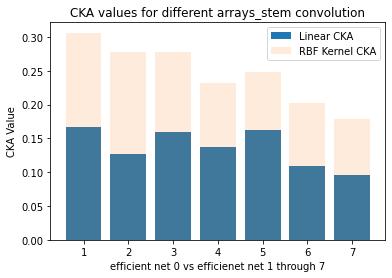

In [30]:
linear_values = [0.16664626144896427, 0.1274292095179526, 0.15996576082470249, 0.13783065534870356, 0.16214494100451615, 0.10949477570501145, 0.09523552256773381]
kernel_values = [0.30614377417333494, 0.2772377812465519, 0.27809430852611944, 0.2324096339588194, 0.24868599592275337, 0.20217840777204704, 0.17866592757739977]
plot_cka_values(linear_values, kernel_values, "_stem convolution")


In [31]:
def cca(X, Y):
    # Stack X and Y horizontally to create a combined array
    Z = np.hstack((X, Y))
    
    # Calculate the covariance matrix of Z
    C_ZZ = np.cov(Z, rowvar=False)
    
    # Calculate the covariance matrices of X and Y
    C_XX = C_ZZ[:X.shape[1], :X.shape[1]]
    C_YY = C_ZZ[X.shape[1]:, X.shape[1]:]
    
    # Calculate the cross-covariance matrix of X and Y
    C_XY = C_ZZ[:X.shape[1], X.shape[1]:]
    
    # Calculate the singular value decomposition of C_XY
    U, s, Vh = svd(C_XY)
    
    # Calculate the canonical correlations
    r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))
    
    # Calculate the canonical weights for X and Y
    W_X = U[:, :r.size]
    W_Y = Vh[:r.size, :]
    
    # Return the canonical correlations and weights
    return r, W_X, W_Y

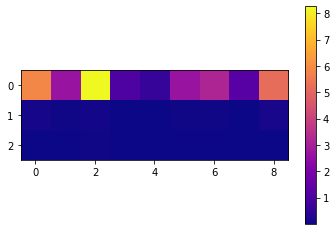

In [32]:
r, wx, wy = cca(arr_0, arr_1)
# Reshape the array to a (3, 9) shape
arr = r.reshape((3, 9))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()

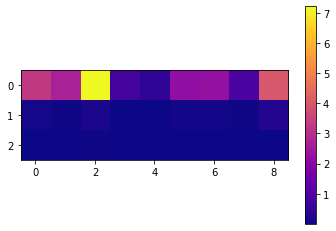

In [33]:
r, wx, wy = cca(arr_0, arr_2)
# Reshape the array to a (3, 9) shape
arr = r.reshape((3, 9))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()

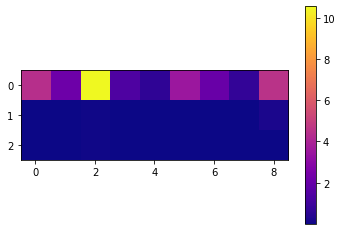

In [34]:
r, wx, wy = cca(padding(arr_0, 40,27), arr_3)
# Reshape the array to a (3, 9) shape
arr = r.reshape((3, 9))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()

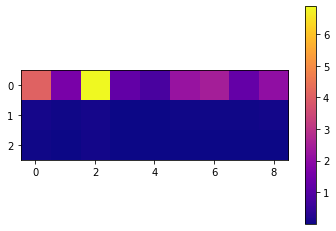

In [35]:
r, wx, wy = cca(padding(arr_0, 48,27), arr_4)
# Reshape the array to a (3, 9) shape
arr = r.reshape((3, 9))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()

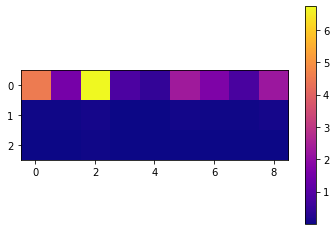

In [36]:
r, wx, wy = cca(padding(arr_0, 48,27), arr_5)
# Reshape the array to a (3, 9) shape
arr = r.reshape((3, 9))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()

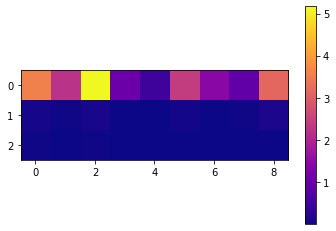

In [37]:
r, wx, wy = cca(padding(arr_0, 56,27), arr_6)
# Reshape the array to a (3, 9) shape
arr = r.reshape((3, 9))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()

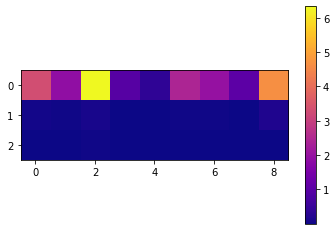

In [38]:
r, wx, wy = cca(padding(arr_0, 64,27), arr_7)
# Reshape the array to a (3, 9) shape
arr = r.reshape((3, 9))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()

The following code is for the conv_head layer that has more weights


In [39]:
temp_0 = model_0._conv_head
temp_1 = model_1._conv_head
temp_2 = model_2._conv_head
temp_3 = model_3._conv_head
temp_4 = model_4._conv_head
temp_5 = model_5._conv_head
temp_6 = model_6._conv_head
temp_7 = model_7._conv_head

In [40]:
def reshape2(layer):
  # Get the weights tensor from the layer
  weights = layer.weight.cpu()
  weights = torch.squeeze(weights)
  # print(weights.shape)  
  # # Get the shape of the weights tensor
  shape = list(weights.shape)
  
  # Convert the weights tensor to a numpy array
  np_arr = weights.detach().numpy()
  print(np_arr.shape)
  # Return the numpy array
  return np_arr

In [41]:
arr_0 = reshape2(temp_0)
arr_1 = reshape2(temp_1)
arr_2 = reshape2(temp_2)
arr_3 = reshape2(temp_3)
arr_4 = reshape2(temp_4)
arr_5 = reshape2(temp_5)
arr_6 = reshape2(temp_6)
arr_7 = reshape2(temp_7)

(1280, 320)
(1280, 320)
(1408, 352)
(1536, 384)
(1792, 448)
(2048, 512)
(2304, 576)
(2560, 640)


In [42]:
print('Linear CKA, between arr_0 and arr_1: {}'.format(linear_CKA(arr_0, arr_1)))
print('RBF Kernel CKA, between arr_0 and arr_1: {}'.format(kernel_CKA(arr_0, arr_1)))

print('Linear CKA, between arr_0 and arr_2: {}'.format(linear_CKA(padding(arr_0, 1408,352), arr_2)))
print('RBF Kernel CKA, between arr_0 and arr_2: {}'.format(kernel_CKA(padding(arr_0, 1408,352), arr_2)))

print('Linear CKA, between arr_0 and arr_3: {}'.format(linear_CKA(padding(arr_0, 1536,384), arr_3)))
print('RBF Kernel CKA, between arr_0 and arr_3: {}'.format(kernel_CKA(padding(arr_0, 1536,384), arr_3)))

print('Linear CKA, between arr_0 and arr_4: {}'.format(linear_CKA(padding(arr_0, 1792,448), arr_4)))
print('RBF Kernel CKA, between arr_0 and arr_4: {}'.format(kernel_CKA(padding(arr_0, 1792,448), arr_4)))

print('Linear CKA, between arr_0 and arr_5: {}'.format(linear_CKA(padding(arr_0, 2048,512), arr_5)))
print('RBF Kernel CKA, between arr_0 and arr_5: {}'.format(kernel_CKA(padding(arr_0, 2048,512), arr_5)))

print('Linear CKA, between arr_0 and arr_6: {}'.format(linear_CKA(padding(arr_0, 2304,576), arr_6)))
print('RBF Kernel CKA, between arr_0 and arr_6: {}'.format(kernel_CKA(padding(arr_0, 2304, 576), arr_6)))

print('Linear CKA, between arr_0 and arr_7: {}'.format(linear_CKA(padding(arr_0, 2560, 640), arr_7)))
print('RBF Kernel CKA, between arr_0 and arr_7: {}'.format(kernel_CKA(padding(arr_0, 2560, 640), arr_7)))


Linear CKA, between arr_0 and arr_1: 0.21527234907735762
RBF Kernel CKA, between arr_0 and arr_1: 0.31604601697780627
Linear CKA, between arr_0 and arr_2: 0.20626094968895176
RBF Kernel CKA, between arr_0 and arr_2: 0.29630759124320455
Linear CKA, between arr_0 and arr_3: 0.19749394952623364
RBF Kernel CKA, between arr_0 and arr_3: 0.2672405810710324
Linear CKA, between arr_0 and arr_4: 0.1726925517362404
RBF Kernel CKA, between arr_0 and arr_4: 0.2006905814805139
Linear CKA, between arr_0 and arr_5: 0.1549823965978021
RBF Kernel CKA, between arr_0 and arr_5: 0.1230725735220733
Linear CKA, between arr_0 and arr_6: 0.13482343682420578
RBF Kernel CKA, between arr_0 and arr_6: 0.09466554475968712
Linear CKA, between arr_0 and arr_7: 0.12775029498640406
RBF Kernel CKA, between arr_0 and arr_7: 0.08020335589426972


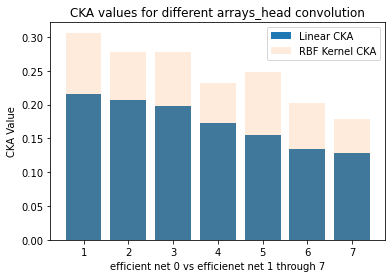

In [43]:
linear_values = [0.21527234907735762,0.20626094968895176,0.19749394952623364,0.1726925517362404,0.1549823965978021,0.13482343682420578,0.12775029498640406]
rbf_values = [0.31604601697780627,0.29630759124320455,0.2672405810710324,0.2006905814805139,0.1230725735220733,0.09466554475968712,0.08020335589426972]
plot_cka_values(linear_values, kernel_values, "_head convolution")


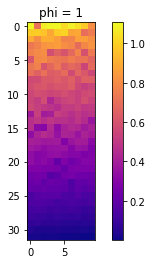

In [44]:
r, wx, wy = cca(arr_0, arr_1)
# Reshape the array to a (32, 10) shape
arr = r.reshape((32,10))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 1")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()

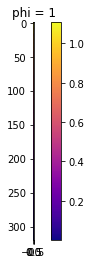

In [45]:
r, wx, wy = cca(arr_0, arr_1)
# Reshape the array to a (320, 1) shape
arr = r.reshape((320,1))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 1")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()

<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


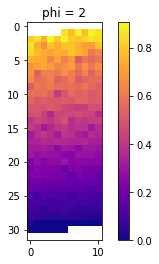

In [46]:
r, wx, wy = cca(padding(arr_0, 1408, 352), arr_2)
r.shape
# Reshape the array to a (32, 11) shape
arr = r.reshape((32, 11))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 2")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


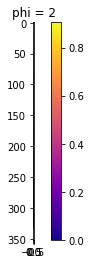

In [47]:
r, wx, wy = cca(padding(arr_0, 1408, 352), arr_2)
r.shape
# Reshape the array to a (32*11, 1) shape
arr = r.reshape((32*11, 1))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 2")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


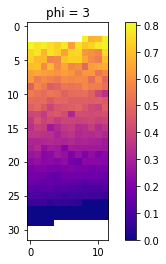

In [48]:
r, wx, wy = cca(padding(arr_0, 1536, 384), arr_3)
r.shape
# Reshape the array to a (32, 12) shape
arr = r.reshape((32, 12))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 3")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


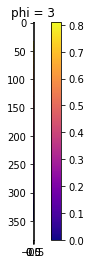

In [49]:
r, wx, wy = cca(padding(arr_0, 1536, 384), arr_3)
r.shape
# Reshape the array to a (32*12, 1) shape
arr = r.reshape((32*12, 1))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 3")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


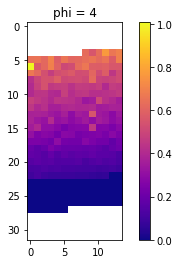

In [50]:
r, wx, wy = cca(padding(arr_0, 1792, 448), arr_4)
r.shape
# Reshape the array to a (32, 14) shape
arr = r.reshape((32, 14))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 4")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


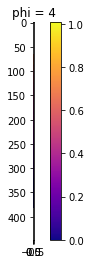

In [51]:
r, wx, wy = cca(padding(arr_0, 1792, 448), arr_4)
r.shape
# Reshape the array to a (32*14, 1) shape
arr = r.reshape((32*14, 1))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 4")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


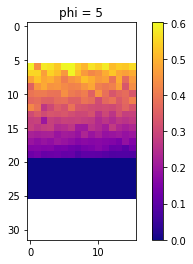

In [52]:
r, wx, wy = cca(padding(arr_0, 2048, 512), arr_5)
r.shape
# Reshape the array to a (32, 16) shape
arr = r.reshape((32, 16))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 5")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


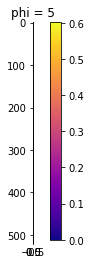

In [53]:
r, wx, wy = cca(padding(arr_0, 2048, 512), arr_5)
r.shape
# Reshape the array to a (32*16, 1) shape
arr = r.reshape((32*16, 1))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 5")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


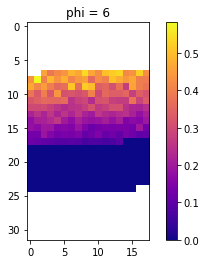

In [54]:
r, wx, wy = cca(padding(arr_0, 2304, 576), arr_6)
r.shape
# Reshape the array to a (32, 18) shape
arr = r.reshape((32, 18))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 6")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


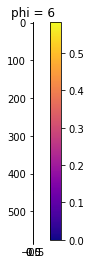

In [55]:
r, wx, wy = cca(padding(arr_0, 2304, 576), arr_6)
r.shape
# Reshape the array to a (32*18, 1) shape
arr = r.reshape((32*18, 1))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 6")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


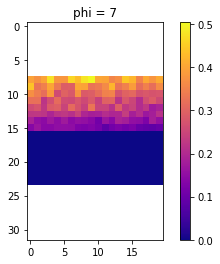

In [56]:
r, wx, wy = cca(padding(arr_0, 2560, 640), arr_7)
r.shape
# Reshape the array to a (32, 20) shape
arr = r.reshape((32, 20))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 7")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


<ipython-input-31-b226a3138da1>:19: RuntimeWarning: divide by zero encountered in true_divide
  r = s / np.sqrt(np.diag(C_XX) * np.diag(C_YY))


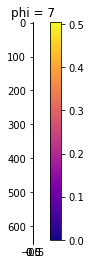

In [57]:
r, wx, wy = cca(padding(arr_0, 2560, 640), arr_7)
r.shape
# Reshape the array to a (32*20, 1) shape
arr = r.reshape((32*20, 1))

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the heatmap
plt.title("phi = 7")
im = ax.imshow(arr, cmap='plasma')

# Add a colorbar to the figure
fig.colorbar(im, ax=ax)

# Show the plot
plt.show()


In [58]:
def count_parameters(model):
  
    table = PrettyTable(["Modules", "Parameters"])# Initialize table and total parameter count
    total_params = 0
    for name, parameter in model.named_parameters(): # Iterate over model's named parameters
        if not parameter.requires_grad: continue # Skip parameters that do not require gradients
        params = parameter.numel()# Get number of parameters and add to table and total count
        table.add_row([name, params])
        total_params+=params
    # print(table)
    # print(f"Total Trainable Params: {total_params}")
    return total_params

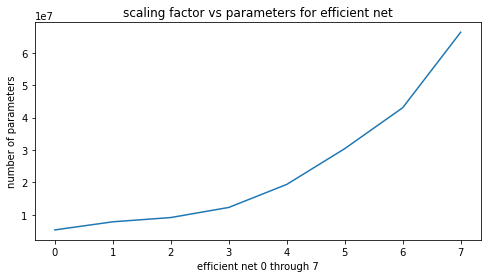

In [59]:
y = []
y.append(count_parameters(model_0))
y.append(count_parameters(model_1))
y.append(count_parameters(model_2))
y.append(count_parameters(model_3))
y.append(count_parameters(model_4))
y.append(count_parameters(model_5))
y.append(count_parameters(model_6))
y.append(count_parameters(model_7))
x = [0,1,2,3,4,5,6,7]
plt.figure(figsize = (8,4))
plt.title("scaling factor vs parameters for efficient net")
plt.xlabel("efficient net 0 through 7")
plt.ylabel("number of parameters")
plt.plot(x,y)

In [60]:
def _flops(layer, ip):
    input = torch.randn(1, ip, 224, 224) # Generate random input tensor
    flops, params = profile(layer, inputs=input) # Calculate FLOPS and number of parameters for the layer
    return flops

In [61]:
ip = torch.rand(1,3,224,224).to(dev)
model_0 = model_0.to(dev)
temp = count_ops(model_0, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              802816    
mul               802816    
_blocks_0__bn1    802816    
mul_1             802816    
mul_2             16        
mul_3             802816    
_blocks_0__bn2    401408    
_blocks_1__bn0    2408448   
mul_4             2408448   
_blocks_1__bn1    602112    
mul_5             602112    
mul_6             8         
mul_7             602112    
_blocks_1__bn2    150528    
_blocks_2__bn0    903168    
mul_8             903168    
_blocks_2__bn1    903168    
mul_9             903168    
mul_10            12        
mul_11            903168    
_blocks_2__bn2    150528    
add               150528    
_blocks_3__bn0    903168    
mul_12            903168    
_blocks_3__bn1    225792    
mul_13            225792    
mul_14            12        
mul_15            225792    
_blocks_3__bn2    62720     
_blocks_4__bn0    376320    
mul_16            376320    
_blocks_4__bn1    376320    
mul_17        

In [62]:
ip = torch.rand(1,3,224,224).to(dev)
model_1 = model_1.to(dev)
temp = count_ops(model_1, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              802816    
mul               802816    
_blocks_0__bn1    802816    
mul_1             802816    
mul_2             16        
mul_3             802816    
_blocks_0__bn2    401408    
_blocks_1__bn1    401408    
mul_4             401408    
mul_5             8         
mul_6             401408    
_blocks_1__bn2    401408    
add               401408    
_blocks_2__bn0    2408448   
mul_7             2408448   
_blocks_2__bn1    602112    
mul_8             602112    
mul_9             8         
mul_10            602112    
_blocks_2__bn2    150528    
_blocks_3__bn0    903168    
mul_11            903168    
_blocks_3__bn1    903168    
mul_12            903168    
mul_13            12        
mul_14            903168    
_blocks_3__bn2    150528    
add_1             150528    
_blocks_4__bn0    903168    
mul_15            903168    
_blocks_4__bn1    903168    
mul_16            903168    
mul_17        

In [63]:
ip = torch.rand(1,3,224,224).to(dev)
model_2 = model_2.to(dev)
temp = count_ops(model_2, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              802816    
mul               802816    
_blocks_0__bn1    802816    
mul_1             802816    
mul_2             16        
mul_3             802816    
_blocks_0__bn2    401408    
_blocks_1__bn1    401408    
mul_4             401408    
mul_5             8         
mul_6             401408    
_blocks_1__bn2    401408    
add               401408    
_blocks_2__bn0    2408448   
mul_7             2408448   
_blocks_2__bn1    602112    
mul_8             602112    
mul_9             8         
mul_10            602112    
_blocks_2__bn2    150528    
_blocks_3__bn0    903168    
mul_11            903168    
_blocks_3__bn1    903168    
mul_12            903168    
mul_13            12        
mul_14            903168    
_blocks_3__bn2    150528    
add_1             150528    
_blocks_4__bn0    903168    
mul_15            903168    
_blocks_4__bn1    903168    
mul_16            903168    
mul_17        

In [64]:
ip = torch.rand(1,3,224,224).to(dev)
model_3 = model_3.to(dev)
temp = count_ops(model_3, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              1003520   
mul               1003520   
_blocks_0__bn1    1003520   
mul_1             1003520   
mul_2             20        
mul_3             1003520   
_blocks_0__bn2    602112    
_blocks_1__bn1    602112    
mul_4             602112    
mul_5             12        
mul_6             602112    
_blocks_1__bn2    602112    
add               602112    
_blocks_2__bn0    3612672   
mul_7             3612672   
_blocks_2__bn1    903168    
mul_8             903168    
mul_9             12        
mul_10            903168    
_blocks_2__bn2    200704    
_blocks_3__bn0    1204224   
mul_11            1204224   
_blocks_3__bn1    1204224   
mul_12            1204224   
mul_13            16        
mul_14            1204224   
_blocks_3__bn2    200704    
add_1             200704    
_blocks_4__bn0    1204224   
mul_15            1204224   
_blocks_4__bn1    1204224   
mul_16            1204224   
mul_17        

In [65]:
ip = torch.rand(1,3,224,224).to(dev)
model_4 = model_4.to(dev)
temp = count_ops(model_4, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              1204224   
mul               1204224   
_blocks_0__bn1    1204224   
mul_1             1204224   
mul_2             24        
mul_3             1204224   
_blocks_0__bn2    602112    
_blocks_1__bn1    602112    
mul_4             602112    
mul_5             12        
mul_6             602112    
_blocks_1__bn2    602112    
add               602112    
_blocks_2__bn0    3612672   
mul_7             3612672   
_blocks_2__bn1    903168    
mul_8             903168    
mul_9             12        
mul_10            903168    
_blocks_2__bn2    200704    
_blocks_3__bn0    1204224   
mul_11            1204224   
_blocks_3__bn1    1204224   
mul_12            1204224   
mul_13            16        
mul_14            1204224   
_blocks_3__bn2    200704    
add_1             200704    
_blocks_4__bn0    1204224   
mul_15            1204224   
_blocks_4__bn1    1204224   
mul_16            1204224   
mul_17        

In [66]:
ip = torch.rand(1,3,224,224).to(dev)
model_5 = model_5.to(dev)
temp = count_ops(model_5, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              1204224   
mul               1204224   
_blocks_0__bn1    1204224   
mul_1             1204224   
mul_2             24        
mul_3             1204224   
_blocks_0__bn2    602112    
_blocks_1__bn1    602112    
mul_4             602112    
mul_5             12        
mul_6             602112    
_blocks_1__bn2    602112    
add               602112    
_blocks_2__bn1    602112    
mul_7             602112    
mul_8             12        
mul_9             602112    
_blocks_2__bn2    602112    
add_1             602112    
_blocks_3__bn0    3612672   
mul_10            3612672   
_blocks_3__bn1    903168    
mul_11            903168    
mul_12            12        
mul_13            903168    
_blocks_3__bn2    250880    
_blocks_4__bn0    1505280   
mul_14            1505280   
_blocks_4__bn1    1505280   
mul_15            1505280   
mul_16            20        
mul_17            1505280   
_blocks_4__bn2

In [67]:
ip = torch.rand(1,3,224,224).to(dev)
model_6 = model_6.to(dev)
temp = count_ops(model_6, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              1404928   
mul               1404928   
_blocks_0__bn1    1404928   
mul_1             1404928   
mul_2             28        
mul_3             1404928   
_blocks_0__bn2    802816    
_blocks_1__bn1    802816    
mul_4             802816    
mul_5             16        
mul_6             802816    
_blocks_1__bn2    802816    
add               802816    
_blocks_2__bn1    802816    
mul_7             802816    
mul_8             16        
mul_9             802816    
_blocks_2__bn2    802816    
add_1             802816    
_blocks_3__bn0    4816896   
mul_10            4816896   
_blocks_3__bn1    1204224   
mul_11            1204224   
mul_12            16        
mul_13            1204224   
_blocks_3__bn2    250880    
_blocks_4__bn0    1505280   
mul_14            1505280   
_blocks_4__bn1    1505280   
mul_15            1505280   
mul_16            20        
mul_17            1505280   
_blocks_4__bn2

In [68]:
ip = torch.rand(1,3,224,224).to(dev)
model_7 = model_7.to(dev)
temp = count_ops(model_7, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              1605632   
mul               1605632   
_blocks_0__bn1    1605632   
mul_1             1605632   
mul_2             32        
mul_3             1605632   
_blocks_0__bn2    802816    
_blocks_1__bn1    802816    
mul_4             802816    
mul_5             16        
mul_6             802816    
_blocks_1__bn2    802816    
add               802816    
_blocks_2__bn1    802816    
mul_7             802816    
mul_8             16        
mul_9             802816    
_blocks_2__bn2    802816    
add_1             802816    
_blocks_3__bn1    802816    
mul_10            802816    
mul_11            16        
mul_12            802816    
_blocks_3__bn2    802816    
add_2             802816    
_blocks_4__bn0    4816896   
mul_13            4816896   
_blocks_4__bn1    1204224   
mul_14            1204224   
mul_15            16        
mul_16            1204224   
_blocks_4__bn2    301056    
_blocks_5__bn0

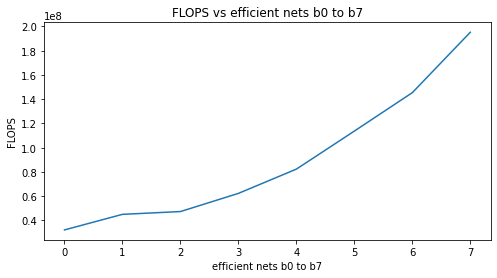

In [69]:
x = [0,1,2,3,4,5,6,7]
y = [32168224, 45013672,  47302476, 62296280, 82313720, 113692296, 145375928, 195198856]
plt.figure(figsize = (8,4))
plt.title("FLOPS vs efficient nets b0 to b7")
plt.xlabel("efficient nets b0 to b7")
plt.ylabel("FLOPS")
plt.plot(x,y)

In [72]:
ip = torch.rand(1,3,168,168).to(dev)
model_0 = model_0.to(dev)
temp = count_ops(model_0, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              451584    
mul               451584    
_blocks_0__bn1    451584    
mul_1             451584    
mul_2             16        
mul_3             451584    
_blocks_0__bn2    225792    
_blocks_1__bn0    1354752   
mul_4             1354752   
_blocks_1__bn1    338688    
mul_5             338688    
mul_6             8         
mul_7             338688    
_blocks_1__bn2    84672     
_blocks_2__bn0    508032    
mul_8             508032    
_blocks_2__bn1    508032    
mul_9             508032    
mul_10            12        
mul_11            508032    
_blocks_2__bn2    84672     
add               84672     
_blocks_3__bn0    508032    
mul_12            508032    
_blocks_3__bn1    127008    
mul_13            127008    
mul_14            12        
mul_15            127008    
_blocks_3__bn2    35280     
_blocks_4__bn0    211680    
mul_16            211680    
_blocks_4__bn1    211680    
mul_17        

In [70]:
ip = torch.rand(1,3,112,112).to(dev)
model_0 = model_0.to(dev)
temp = count_ops(model_0, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              200704    
mul               200704    
_blocks_0__bn1    200704    
mul_1             200704    
mul_2             16        
mul_3             200704    
_blocks_0__bn2    100352    
_blocks_1__bn0    602112    
mul_4             602112    
_blocks_1__bn1    150528    
mul_5             150528    
mul_6             8         
mul_7             150528    
_blocks_1__bn2    37632     
_blocks_2__bn0    225792    
mul_8             225792    
_blocks_2__bn1    225792    
mul_9             225792    
mul_10            12        
mul_11            225792    
_blocks_2__bn2    37632     
add               37632     
_blocks_3__bn0    225792    
mul_12            225792    
_blocks_3__bn1    56448     
mul_13            56448     
mul_14            12        
mul_15            56448     
_blocks_3__bn2    15680     
_blocks_4__bn0    94080     
mul_16            94080     
_blocks_4__bn1    94080     
mul_17        

In [71]:
ip = torch.rand(1,3,56,56).to(dev)
model_0 = model_0.to(dev)
temp = count_ops(model_0, ip) # Count the number of FLOPs

Operation         OPS       
----------------  --------  
_bn0              50176     
mul               50176     
_blocks_0__bn1    50176     
mul_1             50176     
mul_2             16        
mul_3             50176     
_blocks_0__bn2    25088     
_blocks_1__bn0    150528    
mul_4             150528    
_blocks_1__bn1    37632     
mul_5             37632     
mul_6             8         
mul_7             37632     
_blocks_1__bn2    9408      
_blocks_2__bn0    56448     
mul_8             56448     
_blocks_2__bn1    56448     
mul_9             56448     
mul_10            12        
mul_11            56448     
_blocks_2__bn2    9408      
add               9408      
_blocks_3__bn0    56448     
mul_12            56448     
_blocks_3__bn1    14112     
mul_13            14112     
mul_14            12        
mul_15            14112     
_blocks_3__bn2    3920      
_blocks_4__bn0    23520     
mul_16            23520     
_blocks_4__bn1    23520     
mul_17        

<BarContainer object of 4 artists>

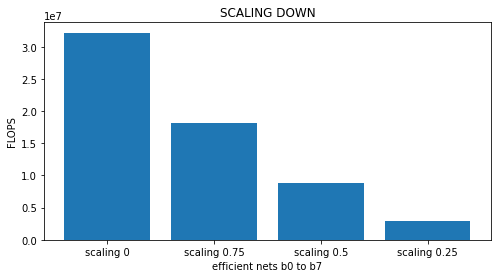

In [79]:
x = ["scaling 0","scaling 0.75", "scaling 0.5", "scaling 0.25"]
y = [32168224,18154704 , 8808896,2978608 ]
plt.figure(figsize = (8,4))

plt.title("SCALING DOWN")
plt.xlabel("efficient nets b0 to b7")
plt.ylabel("FLOPS")
plt.bar(x,y)